# LASSO for Granger Causality

In [137]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import permutations
import graphviz
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline 

In [138]:
plt.rcParams["figure.figsize"] = [30,10]

In [139]:
data = pd.read_csv('output.csv')

In [140]:
data.head()

,x0,x1,x2,x3,x4
0,-1.662189,-0.100499,-1.350334,-1.189624,-0.043115
1,-0.741303,0.998092,-0.468603,-0.055062,-0.594633
2,0.539278,0.684597,-0.147328,0.184362,-0.728728
3,0.958720,-1.276413,0.059814,0.737735,0.608021
4,0.112009,0.217208,1.193067,-0.400950,0.243941


In [283]:
target = 'x1'
predictors = ['x0',  'x2', 'x3', 'x4']
data[[target] + predictors]

,x1,x0,x2,x3,x4
0,-0.100499,-1.662189,-1.350334,-1.189624,-0.043115
1,0.998092,-0.741303,-0.468603,-0.055062,-0.594633
2,0.684597,0.539278,-0.147328,0.184362,-0.728728
3,-1.276413,0.958720,0.059814,0.737735,0.608021
4,0.217208,0.112009,1.193067,-0.400950,0.243941
...,...,...,...,...,...
1005,0.212048,-0.164189,-0.034687,-0.231840,1.779268
1006,0.249115,2.396835,1.402381,-1.465014,0.073279
1007,0.324912,0.964347,-0.102053,1.043437,0.069016
1008,-1.038647,2.404369,0.790429,1.219525,-0.556328


In [261]:
def transform(data, target, predictors, max_lag):
    new = data[[target] + predictors]
    ts = new.to_numpy()
    transformed = []

    max_lag = 5
    for i in range(ts.shape[0]):
        if i >= max_lag:
            start = i - max_lag 
            target = ts[:,0][i]
            regressors = []
            for ii in range(ts.shape[1]):
                regressors.append(list(ts[:,ii][start:i]))
            transformed.append([target] + list(np.array(regressors).flatten()))

    transformed = np.array(transformed)

    y = transformed[:,0]
    x = transformed[:,1:]
    
    return x, y 

In [262]:
x, y  = transform(data, 'x0', ['x1', 'x2', 'x3', 'x4'], 5)

In [309]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

In [321]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(x, y)
alpha_bic_ = model_bic.alpha_

In [322]:
model_bic.criterion_

array([1005.        , 1005.65393543, 1007.53236658, 1006.97156946,
       1007.94469957, 1008.22865728, 1009.50876682, 1010.12467242,
       1009.60890474, 1009.58752096, 1011.27007715, 1012.1052069 ,
       1011.80397941, 1012.9906433 , 1013.71543589, 1014.28374124,
       1014.99277439, 1015.82829482, 1017.11641094, 1018.63550669,
       1019.10218538, 1020.92437331, 1022.31570437, 1023.54952761,
       1025.48328284, 1027.07152164])

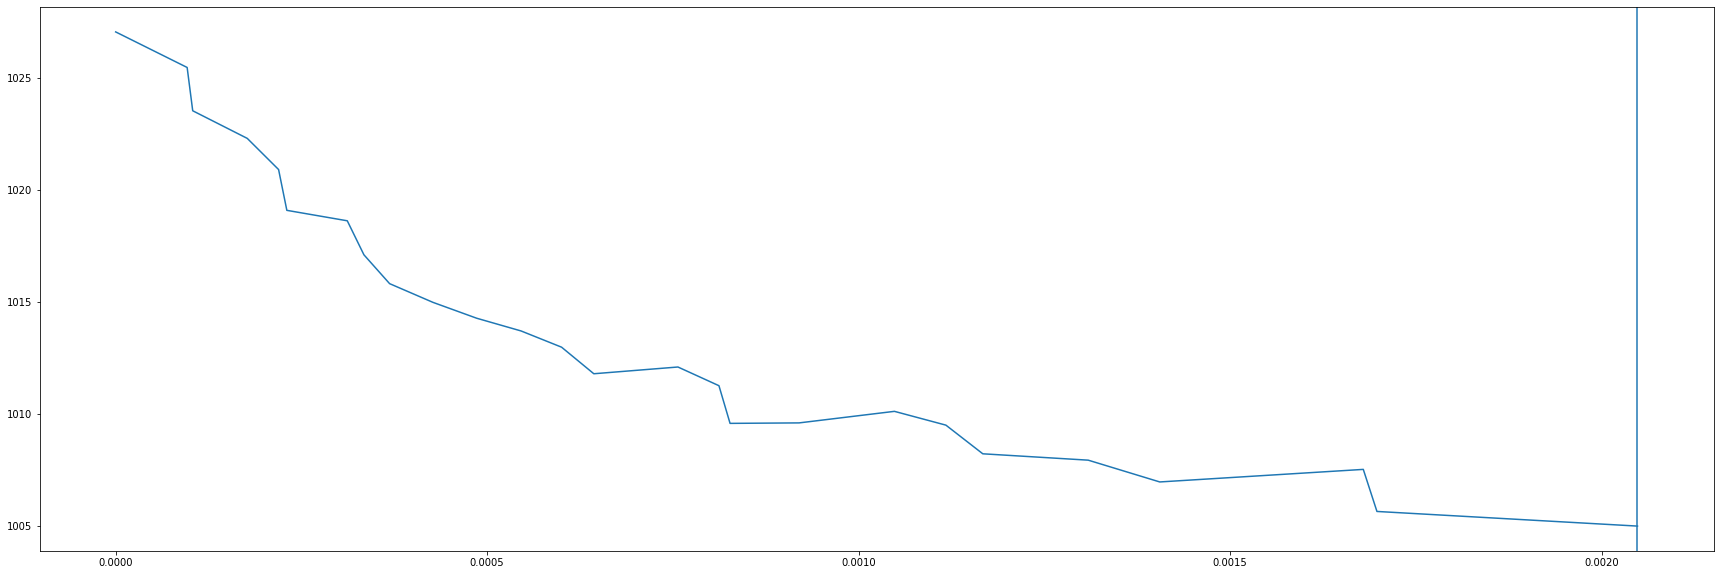

In [323]:
plt.plot(model_bic.alphas_, model_bic.criterion_)
plt.axvline(model_bic.alpha_)

In [264]:
def lasso(x, y, l):
    clf = linear_model.Lasso(alpha=l)
    return clf.fit(x, y).coef_

In [306]:
dag = np.zeros((len(data.columns), len(data.columns)))
nodes = list(data.columns)
max_lag=5

for node in range(len(nodes)):
    nodes_copy = nodes.copy()
    nodes_copy.remove(nodes[node])

    # transform
    x, y  = transform(data, nodes[node], nodes_copy, max_lag)

    # get coefficients
    coefs = lasso(x, y, .5)
    
    # place indicator in DAG matrix 
    cnt=0
    for i in list(range(0, max_lag * len(nodes), max_lag)):
        ll = list(range(max_lag))
        ll.remove(node)
        if i==0:
            if coefs[i:i+5].sum() > 0:
                dag[node][node] = 1
        else:
            if coefs[i:i+5].sum() > 0:
                dag[node][ll[cnt]] = 1
            cnt+=1

In [307]:
dag

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.]])

In [293]:
dag

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
# how to determine lambda 

# lasso time series: uses the generalized cross validation score to select a set of candidate features, and does
# another round of linear regression to select the most significant subset of these candidates


# The second method (lasso lambda or modified lasso time series) sets λ as in [19]. For completeness, 
# we also tested a non-Grangerized version of lasso (without lagging) called lasso standard

In [144]:
i

1009

In [145]:
# shrink parameters to zero
lambdas = np.linspace(0,.9,10) 
coefs = []

for l in lambdas:
    clf = linear_model.Lasso(alpha=l)
    clf.fit(x, y)
    coefs.append(list(clf.coef_))

/Users/barch001/anaconda3/envs/pynew/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/Users/barch001/anaconda3/envs/pynew/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/barch001/anaconda3/envs/pynew/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.7361353849208, tolerance: 0.27404630961113885
  positive)


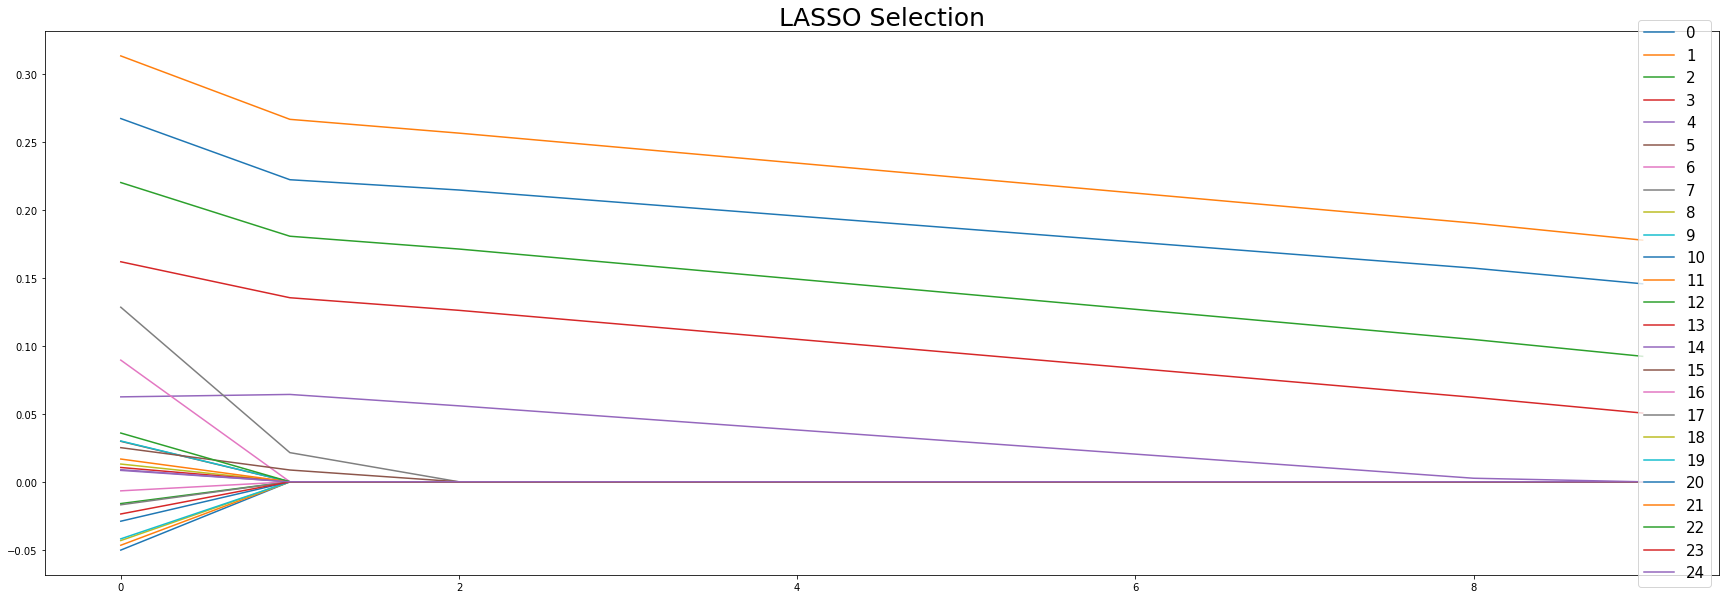

In [146]:
for i in range(np.array(coefs).shape[1]):
    c = np.array(coefs)[:,i]
    plt.plot(c, label='%s' % i)
    
plt.title("LASSO Selection", fontsize=25)
plt.legend(fontsize=15, loc='center right')

In [147]:
coef_df = pd.DataFrame(np.array(coefs))

header = []

for i in data.columns.values:
    for lag in range(1,6):
        header.append('%s_t%s' % (i, lag))

coef_df.columns = header

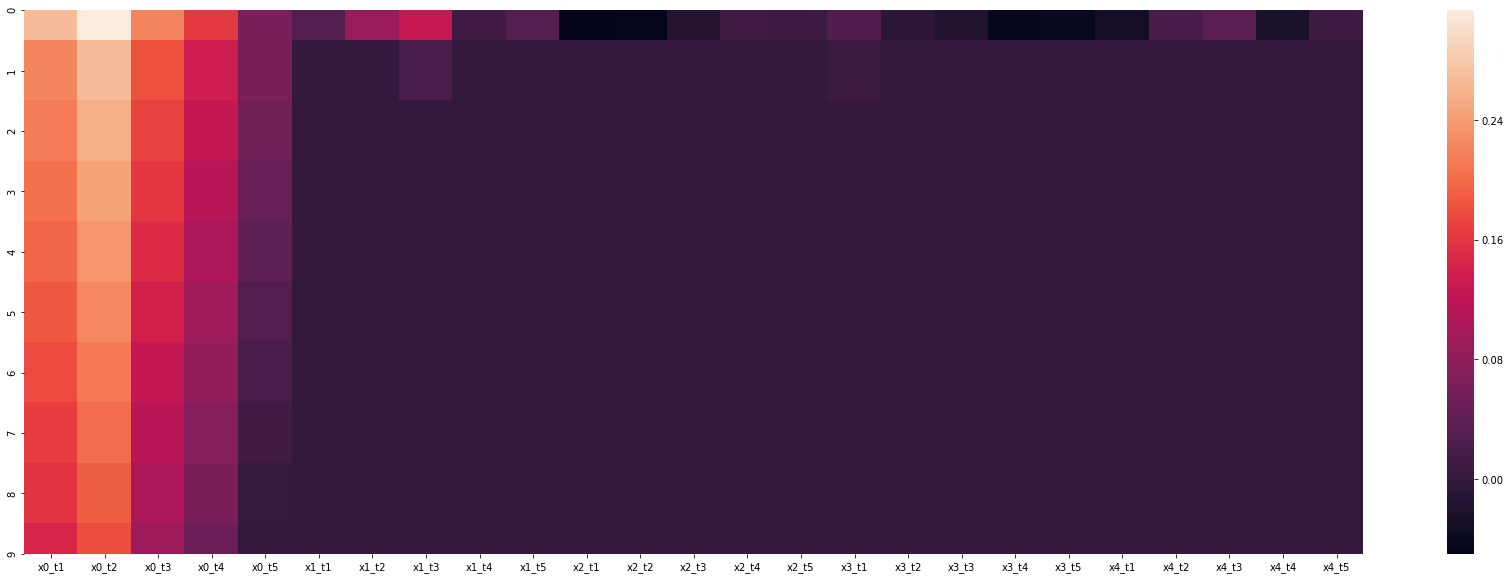

In [148]:
import seaborn as sns

sns.heatmap(coef_df)